# Notebook 2: Feature Engineering

**Objective:** Transform audio into mel spectrograms and extract MIDI targets for training the drum transcription model.

This notebook handles feature extraction, data alignment, and training example creation for our deep learning drum transcription system.

## 1. Imports and Setup

Libraries for audio processing, data manipulation, and visualization. Setting up paths and constants for our feature extraction pipeline.

The GM_DRUM_MAPPING defines the six main drum components we'll transcribe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Optional, Dict, List, Tuple

# Import utility modules
from utils.drum_mapping import GM_DRUM_MAPPING, MAIN_DRUMS, MAIN_DRUM_NAMES
from utils.audio import preprocess_audio, compute_mel_spectrogram
from utils.midi import extract_drum_events, align_spectrogram_with_midi

# Plotting configuration
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["axes.grid"] = True

DATA_DIR = Path("../data")
SUBSET_METADATA_PATH = DATA_DIR / "subset" / "subset_metadata.csv"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

SAMPLE_RATE = 44100
HOP_LENGTH = 512
N_MELS = 229
FMIN = librosa.note_to_hz("C1")
FMAX = librosa.note_to_hz("C8")

## 2. Load Subset Metadata

Loading metadata that points to our audio/MIDI pairs. Each row contains file paths and metadata for a drum performance excerpt we'll process.


In [2]:
SUBSET_METADATA_PATH = Path("../data/subset/subset_metadata.csv")
SUBSET_DATA_PATH = Path("../data/subset/")

print(f"Loading metadata from: {SUBSET_METADATA_PATH}")
df_subset = pd.read_csv(SUBSET_METADATA_PATH)

print("Subset metadata loaded successfully.")
display(df_subset.head())
print(f"Shape of the metadata DataFrame: {df_subset.shape}")

Loading metadata from: ../data/subset/subset_metadata.csv
Subset metadata loaded successfully.


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name,split_set
0,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion,train
1,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock,test
2,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress),train
3,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple,train
4,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal,test


Shape of the metadata DataFrame: (4554, 13)


## 3. Audio Preprocessing

Converting audio files to a consistent format for model input:
- Resampling to unified sample rate 
- Mono conversion
- Peak normalization to [-1,1] range

### 3.1 Define Parameters

We define the target sample rate we want to convert all audio files to. This ensures consistency for the model input. A common choice for audio ML tasks is 22050 Hz, as it captures most relevant frequencies while reducing computational load compared to 44100 Hz.

In [3]:
TARGET_SR: int = 22050
print(f"Target Sample Rate: {TARGET_SR} Hz")

Target Sample Rate: 22050 Hz


### 3.2 Preprocessing Function

We define a function to handle the core preprocessing steps:

1.  **Loading & Resampling:** Load the audio file using `librosa.load`. We specify `sr=TARGET_SR` to resample the audio to our target rate during loading. We also set `mono=True` to convert the audio to mono, as stereo information is often not critical for drum transcription and simplifies the input.
2.  **Normalization:** Perform peak normalization by dividing the audio signal by its maximum absolute value. This scales the audio to the range [-1, 1], preventing issues caused by varying loudness levels across different recordings. We add a small epsilon (`1e-8`) to the denominator to avoid division by zero in case of silent audio.

In [4]:
from typing import Optional


def preprocess_audio(audio_path: Path, target_sr: int) -> Optional[np.ndarray]:
    """
    Loads, resamples, and normalizes an audio file.

    Args:
        audio_path (Path): Path to the input audio file.
        target_sr (int): The target sample rate to resample to.

    Returns:
        Optional[np.ndarray]: The preprocessed audio as a NumPy array,
                               or None if loading fails.
    """
    try:
        # Load audio, resample to target_sr, convert to mono
        audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)

        # Peak normalization
        max_abs_val = np.max(np.abs(audio))
        if max_abs_val > 0:
            audio_normalized = audio / (max_abs_val + 1e-8)
        else:
            audio_normalized = audio

        return audio_normalized
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

### 3.3 Demonstrate on an Example

Let's apply the preprocessing function to one example audio file from our subset and compare it to the original.

In [5]:
# Get the first example from our dataset
example_row = df_subset.iloc[0]

# Build the path to the audio file
audio_path = SUBSET_DATA_PATH / example_row["split_set"] / example_row["audio_filename"]
print(f"Loading audio from: {audio_path}")

try:
    # Load original audio file
    original_audio, original_sr = librosa.load(audio_path, sr=None, mono=True)
    print(f"Loaded audio: {original_sr} Hz, {len(original_audio) / original_sr:.2f}s")

    # Preprocess the audio
    preprocessed_audio = preprocess_audio(audio_path, TARGET_SR)
    if preprocessed_audio is not None:
        print(f"Preprocessed: {TARGET_SR} Hz, {len(preprocessed_audio) / TARGET_SR:.2f}s")
        print(f"Range: [{preprocessed_audio.min():.2f}, {preprocessed_audio.max():.2f}]")
    else:
        print("Preprocessing failed")

except Exception as e:
    print(f"Error loading audio: {e}")
    original_audio, original_sr = None, None
    preprocessed_audio = None

Loading audio from: ../data/subset/train/drummer1/session2/80_punk_144_fill_4-4_37.wav
Loaded audio: 44100 Hz, 1.66s
Preprocessed: 22050 Hz, 1.66s
Range: [-0.93, 1.00]


### 3.4 Visualize Comparison

Now, let's visualize the waveforms of the original and preprocessed audio signals side-by-side.

*   **Original Waveform:** Shows the audio signal as loaded from the file, with its original sample rate and amplitude range.
*   **Preprocessed Waveform:** Shows the audio signal after resampling to `TARGET_SR` and peak normalization. Notice the change in the time axis scale due to resampling and the amplitude axis scale due to normalization (now within [-1, 1]).

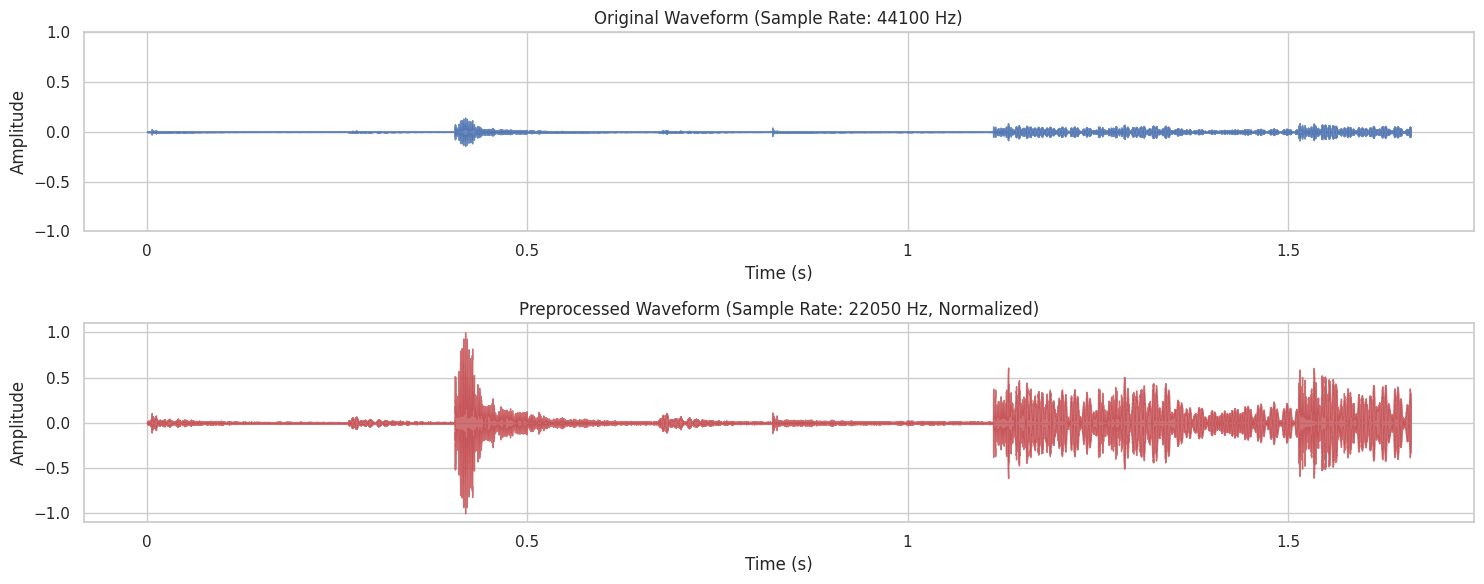

In [6]:
if original_audio is not None and preprocessed_audio is not None:
    plt.figure(figsize=(15, 6))

    # Plot Original Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original_audio, sr=original_sr, alpha=0.8)
    plt.title(f"Original Waveform (Sample Rate: {original_sr} Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.ylim(
        [-1, 1]
    )

    # Plot Preprocessed Waveform
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(preprocessed_audio, sr=TARGET_SR, alpha=0.8, color="r")
    plt.title(f"Preprocessed Waveform (Sample Rate: {TARGET_SR} Hz, Normalized)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.ylim([-1.1, 1.1])  # Normalized range is [-1, 1]

    plt.tight_layout()
    plt.show()
else:
    print("Cannot visualize comparison due to loading/processing errors.")

## 4. Mel Spectrogram Extraction

Converting audio to mel spectrograms - a time-frequency representation that works well for percussion. Testing different parameter combinations to find the optimal time/frequency resolution tradeoff.

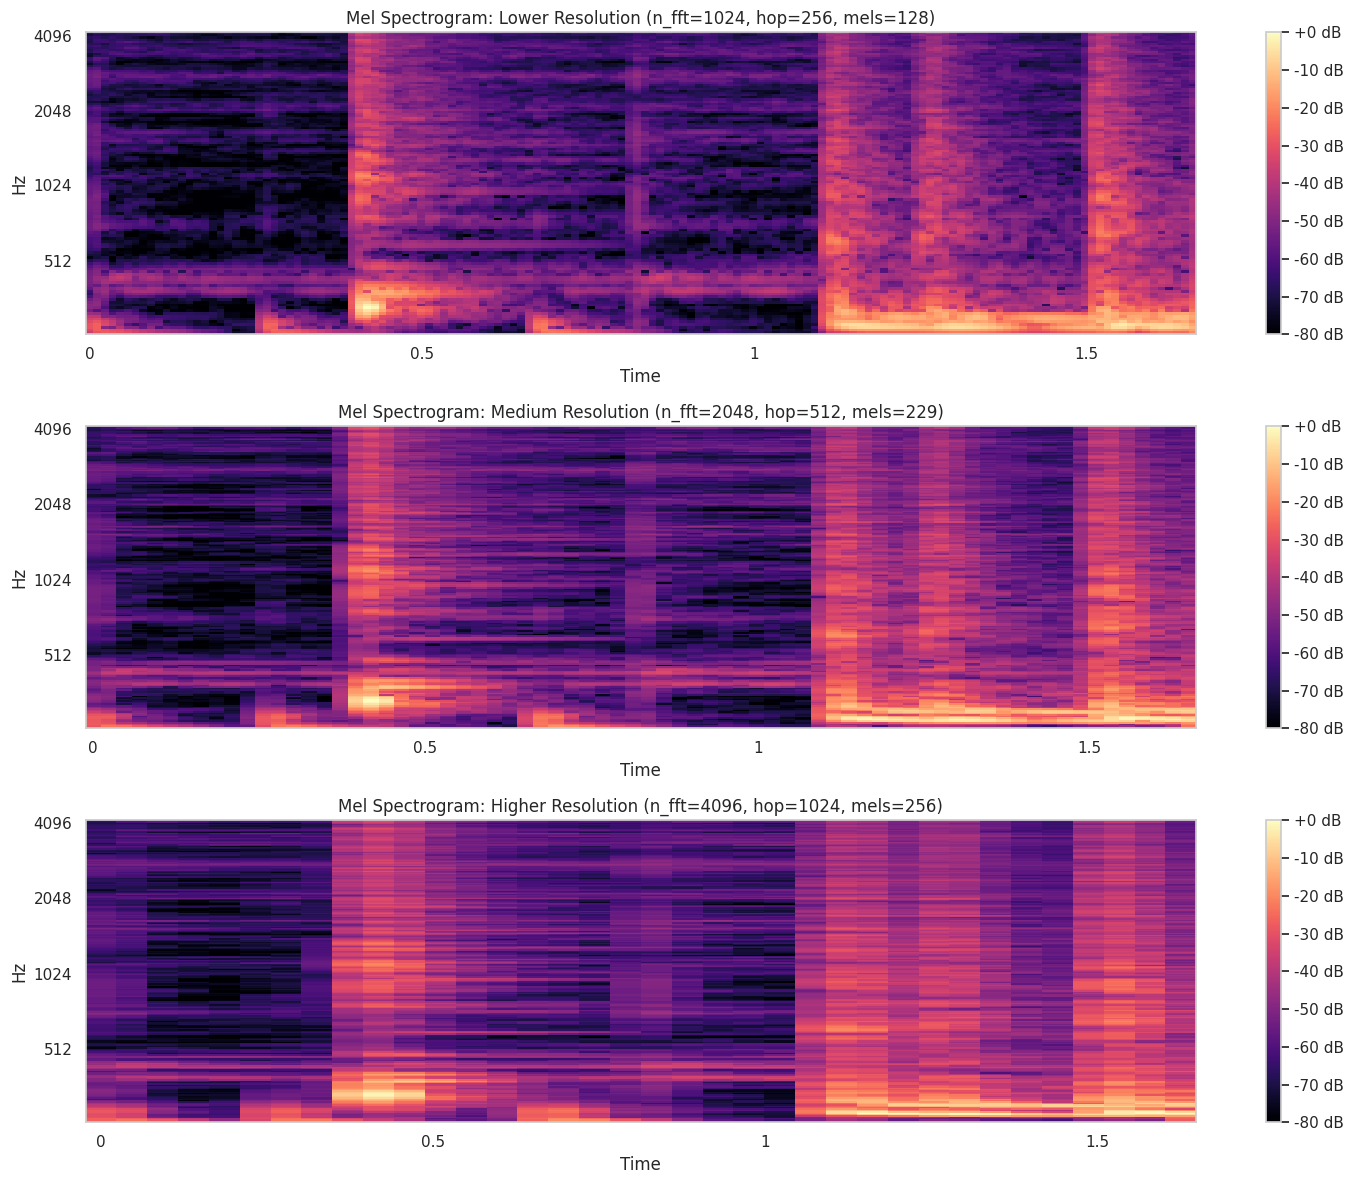

In [7]:
# Example parameter combinations to try
param_sets = [
    {'n_fft': 1024, 'hop_length': 256, 'n_mels': 128, 'title': 'Lower Resolution'},
    {'n_fft': 2048, 'hop_length': 512, 'n_mels': 229, 'title': 'Medium Resolution'},
    {'n_fft': 4096, 'hop_length': 1024, 'n_mels': 256, 'title': 'Higher Resolution'}
]

if preprocessed_audio is not None:
    plt.figure(figsize=(15, 12))

    for i, params in enumerate(param_sets):
        # Compute spectrogram with current parameters
        mel_spec = compute_mel_spectrogram(
            preprocessed_audio,
            TARGET_SR,
            n_fft=params['n_fft'],
            hop_length=params['hop_length'],
            n_mels=params['n_mels'],
            fmin=FMIN,
            fmax=FMAX
        )

        # Plot spectrogram
        plt.subplot(len(param_sets), 1, i+1)
        librosa.display.specshow(
            mel_spec,
            sr=TARGET_SR,
            hop_length=params['hop_length'],
            x_axis='time',
            y_axis='mel',
            fmin=FMIN,
            fmax=FMAX
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram: {params['title']} (n_fft={params['n_fft']}, hop={params['hop_length']}, mels={params['n_mels']})")

    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate spectrograms without preprocessed audio.")

## 5. MIDI Processing

Extracting onset times and velocities for each drum type from MIDI files. These serve as our ground truth labels.

In [8]:
import pretty_midi
from typing import Dict, List, Tuple

def extract_drum_events(midi_path: Path) -> Dict[int, List[Tuple[float, int]]]:
    """
    Extracts drum events from a MIDI file.

    Args:
        midi_path: Path to the MIDI file

    Returns:
        Dictionary mapping drum note numbers to lists of (onset_time, velocity) tuples
    """
    try:
        # Load MIDI file
        pm = pretty_midi.PrettyMIDI(str(midi_path))

        # Find drum tracks
        drum_events = {}

        for instrument in pm.instruments:
            if instrument.is_drum:
                for note in instrument.notes:
                    # Group by pitch (different drum sounds)
                    if note.pitch not in drum_events:
                        drum_events[note.pitch] = []

                    # Store onset time and velocity
                    drum_events[note.pitch].append((note.start, note.velocity))

        return drum_events
    except Exception as e:
        print(f"Error extracting drum events from {midi_path}: {e}")
        return {}


# Test with an example MIDI file
if example_row is not None:
    midi_path = SUBSET_DATA_PATH / example_row["split_set"] / example_row["midi_filename"]

    if midi_path.exists():
        print(f"Extracting drum events from: {midi_path}")
        drum_events = extract_drum_events(midi_path)

        # Display the extracted drum events
        print(f"Found {len(drum_events)} unique drum types in the MIDI file.")

        for pitch, events in drum_events.items():
            drum_name = GM_DRUM_MAPPING.get(pitch, f"Unknown ({pitch})")
            print(f"{drum_name}: {len(events)} hits")

            # Display first few events
            if events:
                print("  First 5 events (time, velocity):")
                for i, (time, vel) in enumerate(sorted(events)[:5]):
                    print(f"    {time:.3f}s: velocity={vel}")
    else:
        print(f"MIDI file not found: {midi_path}")

Extracting drum events from: ../data/subset/train/drummer1/session2/80_punk_144_fill_4-4_37.midi
Found 4 unique drum types in the MIDI file.
Kick: 3 hits
  First 5 events (time, velocity):
    0.000s: velocity=20
    0.265s: velocity=22
    0.672s: velocity=27
Ride: 3 hits
  First 5 events (time, velocity):
    0.007s: velocity=63
    0.411s: velocity=77
    0.823s: velocity=80
Snare: 1 hits
  First 5 events (time, velocity):
    0.405s: velocity=115
Tom: 6 hits
  First 5 events (time, velocity):
    1.113s: velocity=121
    1.126s: velocity=108
    1.252s: velocity=94
    1.270s: velocity=101
    1.515s: velocity=127


## 6. Feature-Target Alignment

Aligning spectrogram frames with MIDI events to create training pairs. Converting time-based MIDI events to frame indices that match our spectrograms.

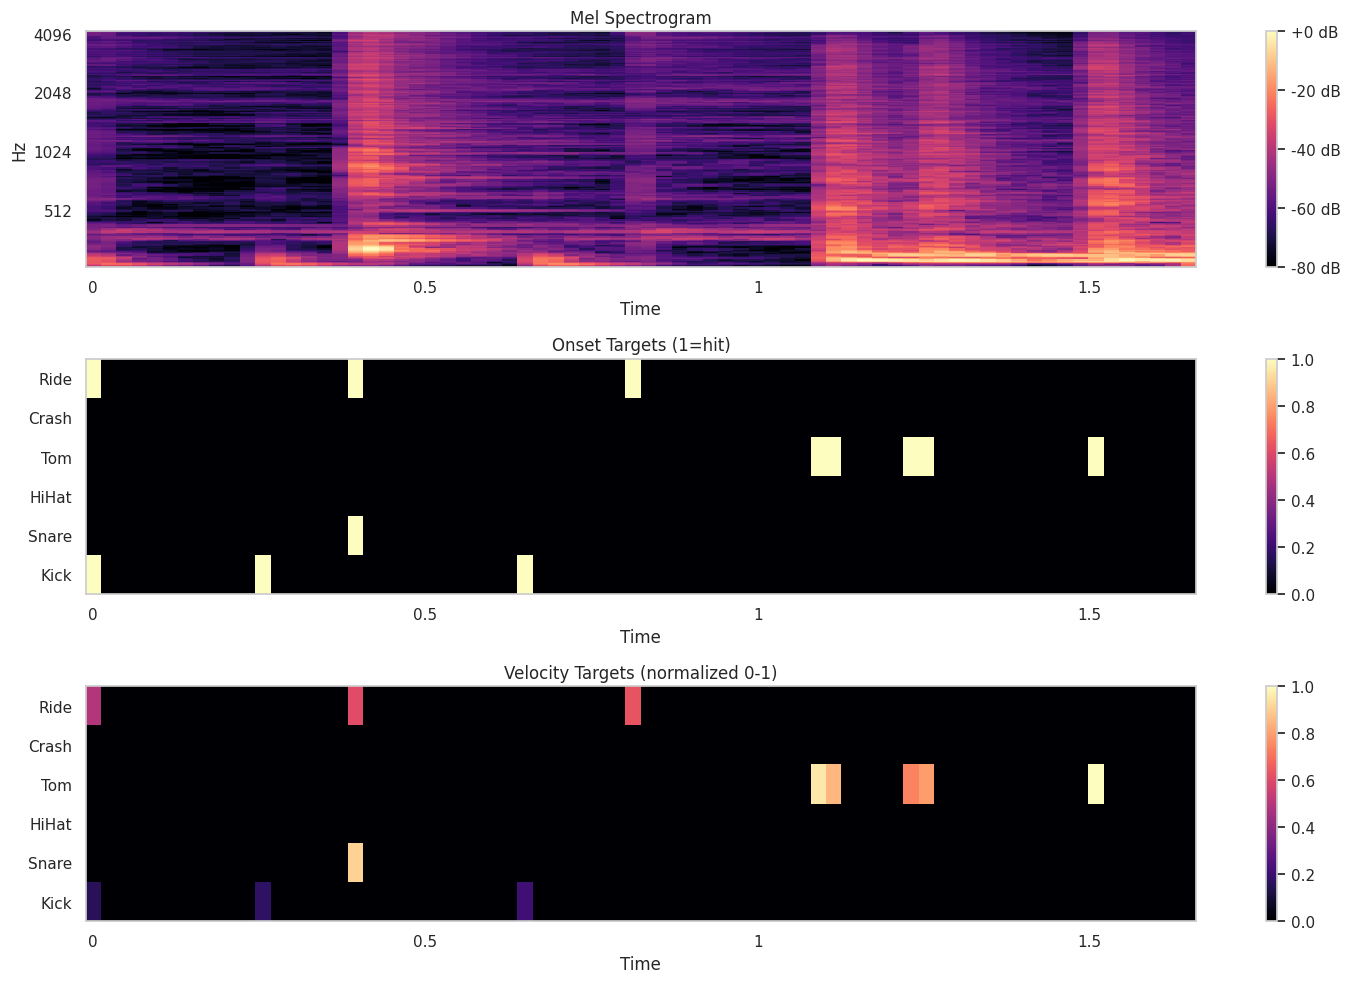

In [9]:
# Test with our example
if preprocessed_audio is not None and 'drum_events' in locals() and drum_events:
    # Compute spectrogram
    mel_spec = compute_mel_spectrogram(
        preprocessed_audio,
        TARGET_SR,
        hop_length=HOP_LENGTH
    )

    # Align with MIDI
    onset_target, velocity_target = align_spectrogram_with_midi(
        mel_spec, drum_events, TARGET_SR, HOP_LENGTH, MAIN_DRUMS
    )

    # Visualize alignment
    plt.figure(figsize=(15, 10))

    # Plot spectrogram
    plt.subplot(3, 1, 1)
    librosa.display.specshow(
        mel_spec,
        sr=TARGET_SR,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        fmin=FMIN,
        fmax=FMAX
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")

    # Plot onset detections
    plt.subplot(3, 1, 2)
    librosa.display.specshow(
        onset_target,
        sr=TARGET_SR,
        hop_length=HOP_LENGTH,
        x_axis='time',
    )
    plt.colorbar()
    plt.yticks(np.arange(len(MAIN_DRUMS)), MAIN_DRUM_NAMES)
    plt.title("Onset Targets (1=hit)")

    # Plot velocities
    plt.subplot(3, 1, 3)
    librosa.display.specshow(
        velocity_target,
        sr=TARGET_SR,
        hop_length=HOP_LENGTH,
        x_axis='time',
    )
    plt.colorbar()
    plt.yticks(np.arange(len(MAIN_DRUMS)), MAIN_DRUM_NAMES)
    plt.title("Velocity Targets (normalized 0-1)")

    plt.tight_layout()
    plt.show()

## 7. Training Example Creation

Putting it all together:
1. Process audio → mel spectrograms (features)
2. Process MIDI → onset/velocity targets (labels)
3. Package as compressed NPZ files for efficient training

In [10]:
def create_and_save_training_example(
    audio_path: Path,
    midi_path: Path,
    output_dir: Path,
    target_sr: int,
    hop_length: int,
    n_mels: int,
    fmin: float,
    fmax: float,
    file_id: str
) -> bool:
    """
    Creates and saves a training example with features and targets.

    Args:
        audio_path: Path to the audio file
        midi_path: Path to the MIDI file
        output_dir: Directory to save the outputs
        target_sr: Target sample rate
        hop_length: Hop length for spectrogram
        n_mels: Number of mel bands
        fmin: Lowest frequency
        fmax: Highest frequency
        file_id: Identifier for the file

    Returns:
        True if successful, False otherwise
    """
    try:
        # Make sure output directory exists
        output_dir.mkdir(parents=True, exist_ok=True)

        # Preprocess audio
        preprocessed_audio = preprocess_audio(audio_path, target_sr)
        if preprocessed_audio is None:
            return False

        # Extract mel spectrogram
        mel_spec = compute_mel_spectrogram(
            preprocessed_audio,
            target_sr,
            hop_length=hop_length,
            n_mels=n_mels,
            fmin=fmin,
            fmax=fmax
        )

        # Extract MIDI events
        drum_events = extract_drum_events(midi_path)
        if not drum_events:
            return False

        # Align features and targets
        onset_target, velocity_target = align_spectrogram_with_midi(
            mel_spec, drum_events, target_sr, hop_length
        )

        # Save to NPZ file
        output_path = output_dir / f"{file_id}.npz"
        np.savez_compressed(
            output_path,
            mel_spec=mel_spec,
            onset_target=onset_target,
            velocity_target=velocity_target,
            audio_path=str(audio_path),
            midi_path=str(midi_path)
        )

        print(f"Saved training example to {output_path}")
        return True

    except Exception as e:
        print(f"Error creating training example for {file_id}: {e}")
        return False


# Test with our example
if example_row is not None:
    audio_path = SUBSET_DATA_PATH / \
        example_row["split_set"] / example_row["audio_filename"]
    midi_path = SUBSET_DATA_PATH / \
        example_row["split_set"] / example_row["midi_filename"]

    if audio_path.exists() and midi_path.exists():
        output_dir = PROCESSED_DATA_DIR / example_row["split_set"]
        file_id = f"{example_row['drummer']}_{Path(example_row['audio_filename']).stem}"

        success = create_and_save_training_example(
            audio_path,
            midi_path,
            output_dir,
            TARGET_SR,
            HOP_LENGTH,
            N_MELS,
            FMIN,
            FMAX,
            file_id
        )

        if success:
            print("Successfully created and saved training example!")
        else:
            print("Failed to create training example.")

Error creating training example for drummer1_80_punk_144_fill_4-4_37: align_spectrogram_with_midi() missing 1 required positional argument: 'main_drums'
Failed to create training example.


## 8. Batch Processing

Scaling up processing to handle multiple files. Using filename indexing to match audio/MIDI pairs regardless of directory structure.

Processing a test batch from each split (train/validation/test) to verify the pipeline works.

In [11]:
def process_dataset_subset(
    df: pd.DataFrame,
    base_path: Path,
    output_dir: Path,
    target_sr: int,
    hop_length: int,
    n_mels: int,
    fmin: float,
    fmax: float,
    audio_midi_maps: Optional[Dict] = None,
    limit: int = None,
    skip_existing: bool = True
) -> int:
    """
    Process a subset of the dataset with simplified file finding.

    Args:
        df: DataFrame containing file metadata
        base_path: Base path to dataset
        output_dir: Output directory for processed files
        target_sr: Target sample rate
        hop_length: Hop length for spectrogram
        n_mels: Number of mel bands
        fmin: Lowest frequency
        fmax: Highest frequency
        audio_midi_maps: Optional pre-built file indexes (for reuse across splits)
        limit: Maximum number of files to process
        skip_existing: Skip files that already exist

    Returns:
        Number of successfully processed files
    """
    # Calculate total number of files to process
    total = min(len(df), limit) if limit else len(df)
    success_count = 0

    # Build or reuse file index
    if audio_midi_maps is None:
        print("Building file index...")
        audio_files = list(base_path.glob("**/*.wav"))
        midi_files = list(base_path.glob("**/*.midi"))

        # Create filename-based lookups (simpler approach)
        audio_map = {path.name: path for path in audio_files}
        midi_map = {path.name: path for path in midi_files}

        audio_midi_maps = {"audio": audio_map, "midi": midi_map}
        print(
            f"Found {len(audio_map)} audio files and {len(midi_map)} MIDI files.")
    else:
        audio_map = audio_midi_maps["audio"]
        midi_map = audio_midi_maps["midi"]

    # Process files
    for i, (_, row) in enumerate(tqdm(df.iterrows(), total=total, desc="Processing files")):
        if limit and i >= limit:
            break

        # Get filenames
        audio_filename = Path(row["audio_filename"]).name
        midi_filename = Path(row["midi_filename"]).name

        # Look up files by name
        audio_path = audio_map.get(audio_filename)
        midi_path = midi_map.get(midi_filename)

        # Skip if files not found
        if not audio_path or not midi_path:
            if i < 10:  # Limited debugging for the first few files
                if not audio_path:
                    print(f"Could not find audio file: {audio_filename}")
                if not midi_path:
                    print(f"Could not find MIDI file: {midi_filename}")
            continue

        # Create unique identifier for the file
        file_id = f"{row['drummer']}_{Path(audio_filename).stem}"

        # Define output path
        file_output_dir = output_dir / row["split_set"]
        output_path = file_output_dir / f"{file_id}.npz"

        # Skip if file exists and skip_existing is True
        if skip_existing and output_path.exists():
            continue

        # Process the file
        if create_and_save_training_example(
            audio_path,
            midi_path,
            file_output_dir,
            target_sr,
            hop_length,
            n_mels,
            fmin,
            fmax,
            file_id
        ):
            success_count += 1

    return success_count, audio_midi_maps

In [12]:
# Process all files in the dataset
processed_count = 0
audio_midi_maps = None  # Will be created in first run and reused

# Increase or remove limit for full processing
batch_size = None  # Set to None to process all files

for split in ['train', 'validation', 'test']:
    print(f"\nProcessing files from {split} set:")
    subset_df = df_subset[df_subset['split_set'] == split]

    count, audio_midi_maps = process_dataset_subset(
        subset_df,
        SUBSET_DATA_PATH,
        PROCESSED_DATA_DIR,
        TARGET_SR,
        HOP_LENGTH,
        N_MELS,
        FMIN,
        FMAX,
        audio_midi_maps=audio_midi_maps,  # Reuse file index
        limit=batch_size,
        skip_existing=True
    )

    processed_count += count
    print(f"Processed {count} files from {split} set")

print(f"\nTotal processed files: {processed_count}")


Processing files from train set:
Building file index...
Found 4528 audio files and 4528 MIDI files.


Processing files:   0%|          | 0/3187 [00:00<?, ?it/s]

Processed 0 files from train set

Processing files from validation set:


Processing files:   0%|          | 0/683 [00:00<?, ?it/s]

Processed 0 files from validation set

Processing files from test set:


Processing files:   0%|          | 0/684 [00:00<?, ?it/s]

Processed 0 files from test set

Total processed files: 0
